Balanced Pure Splits


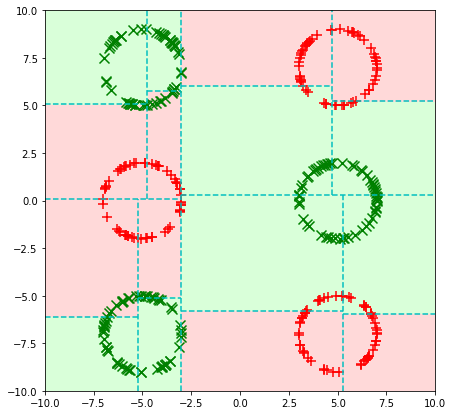

In [2]:
import numpy as np
from sklearn.svm import SVC as csvm
from cs771 import genSyntheticData as gsd
from cs771 import plotData as pd
from cs771 import decisionTree as dt

# Get the Gini coefficient of a node with nPos positive points and nNeg negative points
def getGini( nPos, nNeg ):
    nTot = nPos + nNeg
    # Find the proportion of the positives and negatives in that node
    pPos = nPos/nTot
    pNeg = nNeg/nTot
    # The gini index is always a real number between 0 and 0.5
    # A perfectly pure node has gini index = 0
    # The smaller the gini index the purer the node
    gini = 1 - (pPos**2 + pNeg**2)
    return gini
    
# Get the balance factor of a certain split that sends nLeft and nRight data points to left and right child
def getBalance( nLeft, nRight ):
    # There are several other possible notions of balance as well
    # This one will always return a positive number (which can be arbitrarily large)
    # A perfectly balanced split has balance factor 0
    # The smaller the balance factor the more balanced the split
    balance = max(nLeft, nRight)/min(nLeft, nRight) - 1
    return balance
        
# Create a stump on the basis of gini index and balance factor
def getBalancedGiniStump( X, y, ancestorSplitFeats ):
    # How many data points do I have at this node?
    n = y.size
    bestObjective = float('inf')

    # For each of the features in the data
    for i in range( X.shape[1] ):
        # Do not use the same feature as used by the parent node
        if ancestorSplitFeats.size > 0 and i == ancestorSplitFeats[-1]:
            continue
        # Find out all values at which we can threshold that feature
        candidateThresholds = np.sort( X[:, i] )
        idx = np.argsort( X[:, i] )
        # The cumulative sum trick used here will work only if labels are binary :)
        ySorted = y[idx]
        yCum = np.cumsum( ySorted )
        yCumRev = np.cumsum( ySorted[::-1] )[::-1]
        # For each possible threshold (except the ones at the extreme)
        for j in range( 1, candidateThresholds.size-1 ):
            # Give 0.5 weight to balance and 1 weight to purity of the two nodes
            candidateObjective = 0.5 * getBalance( j+1, n-j-1 ) \
                                + 0.0 * getGini( (yCum[j] + j+1)/2, (j+1 - yCum[j])/2 ) \
                                + 0.0 * getGini( (yCumRev[j+1] + n-j-1)/2, (n-j-1 - yCumRev[j+1])/2 )
            if candidateObjective < bestObjective:
                bestObjective = candidateObjective
                bestFeat = i
                bestThresh = candidateThresholds[j]
                
    return (bestFeat, bestThresh)    

d = 2 
n = 60
r = 2

tmp1 = gsd.genSphericalData( d, n, [-5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [-5, 7], r )
XPos = np.vstack( (tmp1, tmp2, tmp3) )
yPos = np.ones( (3*n,) )

tmp1 = gsd.genSphericalData( d, n, [5, -7], r )
tmp2 = gsd.genSphericalData( d, n, [-5, 0], r )
tmp3 = gsd.genSphericalData( d, n, [5, 7], r )
XNeg = np.vstack( (tmp1, tmp2, tmp3) )
yNeg = -np.ones( (3*n,) )

X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

maxLeafSize = 20
maxDepth = 4
    
dtGini = dt.Tree( maxLeafSize, maxDepth )
dtGini.train( X, y, getBalancedGiniStump )

print("Balanced Pure Splits")
fig = pd.getFigure()
pd.shade2D( dtGini.predict, fig, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
dtGini.drawTreeSplits( fig, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig, color = 'r', marker = '+' )
pd.plot2D( XPos, fig, color = 'g', marker = 'x' )

LwP Splits


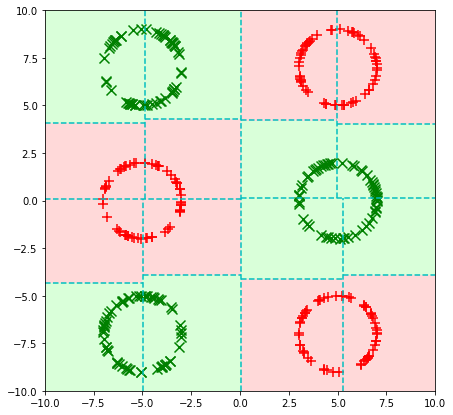

In [3]:
# Create a stump on the basis of LwP
def getLwPStump( X, y, ancestorSplitFeats ):
    n = y.size
    bestObjective = float('inf')

    # For each of the features in the data
    for i in range( X.shape[1] ):
        # Do not use the same feature as used by the parent node
        if ancestorSplitFeats.size > 0 and i == ancestorSplitFeats[-1]:
            continue
        thresh = (np.mean( X[y > 0, i] ) + np.mean( X[y < 0, i] ))/2
        nLeftPos = np.sum( y[np.logical_and( y > 0, X[:, i] <= thresh )] )
        nLeftNeg = np.sum( y[np.logical_and( y < 0, X[:, i] <= thresh )] )
        nRightPos = np.sum( y[np.logical_and( y > 0, X[:, i] > thresh )] )
        nRightNeg = np.sum( y[np.logical_and( y < 0, X[:, i] > thresh )] )
        candidateObjective = 0.5 * getBalance( nLeftPos + nLeftNeg, nRightPos + nRightNeg ) \
                                + 0.0 * getGini( nLeftPos, nLeftNeg ) \
                                + 0.0 * getGini( nRightPos, nRightNeg )
        if candidateObjective < bestObjective:
            bestObjective = candidateObjective
            bestFeat = i
            bestThresh = thresh
            
    return (bestFeat, bestThresh)

dtLwP = dt.Tree( maxLeafSize, maxDepth )
dtLwP.train( X, y, getLwPStump )

print("LwP Splits")
fig2 = pd.getFigure()
pd.shade2D( dtLwP.predict, fig2, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
dtLwP.drawTreeSplits( fig2, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig2, color = 'r', marker = '+' )
pd.plot2D( XPos, fig2, color = 'g', marker = 'x' )

SVM Splits


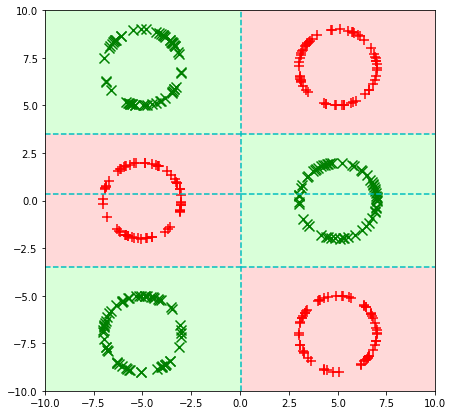

In [4]:
# Create a stump using the C-SVM
def getSVMStump( X, y, ancestorSplitFeats ):
    n = y.size
    bestObjective = float('inf')
    
    # clf stands for classifier
    clf = csvm( kernel = 'linear', C = 1.0 )
    clf.fit( X, y )
    w = clf.coef_[0]
    b = clf.intercept_[0]
    
    # If no feature is able to classify well, choose the widest dimension and split it
    # When splitting, promote balance (no point promoting purity as this is a lost case)
    if max( abs(w) ) < 1e-2:
        bestFeat = np.argmax( np.max( X, axis = 0 ) - np.min( X, axis = 0 ) )
        temp = np.sort( X[:, bestFeat] )
        # Split at the median to promote balance
        bestThresh = (temp[n//2 - 1] + temp[n//2 + 1])/2
    # Else choose the most influential feature and split it so as to get a wide
    # margin along that feature
    else:
        bestFeat = np.argmax( abs(w) )
        suppX = X[clf.support_, :]
        suppy = y[clf.support_]
        bestThresh = (np.mean( suppX[suppy > 0, bestFeat] ) + np.mean( suppX[suppy < 0, bestFeat] ))/2
        
    return (bestFeat, bestThresh)

# This verions needs only 3 splits to perfectly purify the nodes
maxDepth = 3

dtSVM = dt.Tree( maxLeafSize, maxDepth )
dtSVM.train( X, y, getSVMStump )

print("SVM Splits")
fig3 = pd.getFigure()
pd.shade2D( dtSVM.predict, fig3, mode = 'point', xlim = 10, ylim = 10, nBins = 500 )
dtSVM.drawTreeSplits( fig3, xlim = [-10, 10],  ylim = [-10, 10])
pd.plot2D( XNeg, fig3, color = 'r', marker = '+' )
pd.plot2D( XPos, fig3, color = 'g', marker = 'x' )

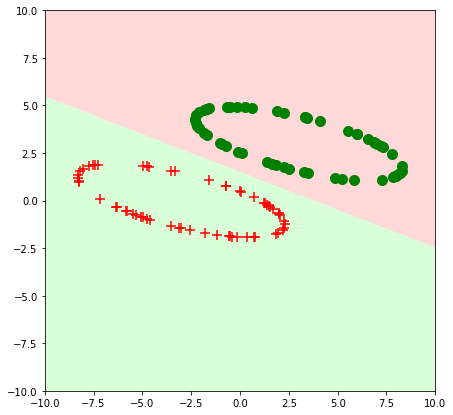

In [5]:
muPos = np.array( [-3,0] )
muNeg = np.array( [3,3] )
cov = np.array( [[16, -14] , [-14, 16]] )

XPos = gsd.genEllipticalData( d, n, muPos, cov )
XNeg = gsd.genEllipticalData( d, n, muNeg, cov )
yPos = np.ones( (n,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

# C-SVM can directly give us nice linear classifiers which, if we had done LwP
# would have required us to do metric learning which can be expensive to do
clf = csvm( kernel = 'linear', C = 0.1 )
clf.fit( X, y )
w = clf.coef_[0]
b = clf.intercept_[0]

def CSVM( X ):
    return X.dot(w) + b

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )

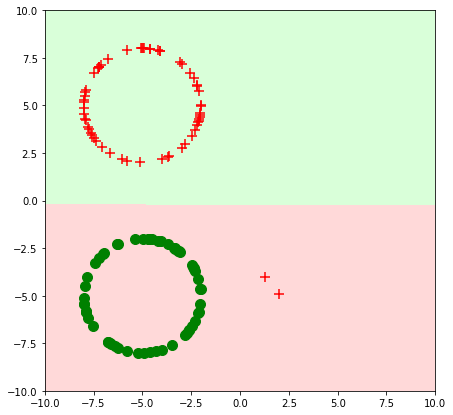

In [6]:
muPos1 = np.array( [-5,5] )
muPos2 = np.array( [1,-5] )
muNeg = np.array( [-5,-5] )
r = 3

tmp1 = gsd.genSphericalData( d, n, muPos1, r)
tmp2 = gsd.genSphericalData( d, n//30, muPos2, r//2 )
XPos = np.vstack( (tmp1, tmp2) )
XNeg = gsd.genSphericalData( d, n, muNeg, r )
yPos = np.ones( (n + n//30,) )
yNeg = -np.ones( (n,) )
X = np.vstack( (XPos, XNeg) )
y = np.concatenate( (yPos, yNeg) )

# C dictates how worried C-SVM gets about ensuring a large margin vs misclassifying points
# A very small value of C tells C-SVM that it is okay to misclassify a few points if that
# means that the margin will be very good on the rest of the points
# A moderate or large value of C will politely request C-SVM to try its level best
# to not misclassify any point as far as possible even if it means sacrificing margin

# If you have lots of data, it should not hurt to keep a moderate or large value of C
# If you have less training data, it is better to keep a small value of C
# In general, C is a hyperparameter that is tuned using validation

# Try setting C = 0.001, 0.01, 0.1, 1 and see what happens - as C increases, CSVM will get
# more worried about misclassifying the outlier red points and will sacrifice margin in an
# effort to perfectly classify every data point
clf = csvm( kernel = 'linear', C = 0.001 )
clf.fit( X, y )
w = clf.coef_[0]
b = clf.intercept_[0]

fig4 = pd.getFigure( 7, 7 )
pd.shade2D( CSVM, fig4, mode = 'batch', xlim = 10, ylim = 10 )
pd.plot2D( XPos, fig4, color = 'r', marker = '+' )
pd.plot2D( XNeg, fig4, color = 'g', marker = 'o' )